In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


$
Importing\;neccessary\;libraries
$

In [0]:
from __future__ import print_function
import argparse
import os
import math
import numpy as np
import numpy.random as npr
import scipy.misc
import imageio
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt 
import cv2
from google.colab.patches import cv2_imshow
import os
from six.moves.urllib.request import urlretrieve
import tarfile
import numpy as np
import pickle
import sys
import PIL
from PIL import Image
from torchvision import models

$
Data\;preprocessing
$

In [0]:
def load_images_from_folder(folder1,folder3):
    x_data=[]
    semantic_y_label=[]
    x_data_names=[]
    semantic_y_label_names=[]
    for filename in os.listdir(folder1):
      if filename!='data':
        x_data_names.append(filename)
    for filename in os.listdir(folder3):
      if filename!='Building':
        semantic_y_label_names.append(filename)
    x_data_names.sort()
    semantic_y_label_names.sort()
    print(x_data_names)
    print(semantic_y_label_names)
    for i in range(len(x_data_names)):
        img = cv2.imread(os.path.join(folder1,x_data_names[i]))
        img2 = cv2.imread(os.path.join(folder3,semantic_y_label_names[i]))
        if img is not None :
            x_data.append(np.array((img)))
            semantic_y_label.append(np.array((img2)))
    return (np.array(x_data),np.array(semantic_y_label))

In [0]:
path1='/content/drive/My Drive/Satellite_data/Inputs'
path3='/content/drive/My Drive/Satellite_data/Labels'
(x_data,semantic_y_label)=load_images_from_folder(path1,path3)
print('%d input images are loaded'%(np.shape(x_data)[0]))
print('Size of images are %d x %d x%d'%(np.shape(x_data)[1]
                                        ,np.shape(x_data)[2]
                                        ,np.shape(x_data)[3]))
print('%d semantic masks are loaded'%(np.shape(semantic_y_label)[0]))
print('Size of images are %d x %d x%d'%(np.shape(semantic_y_label)[1]
                                        ,np.shape(semantic_y_label)[2]
                                        ,np.shape(semantic_y_label)[3]))

['dtv_101001.png', 'dtv_101002.png', 'dtv_101003.png', 'dtv_101004.png', 'dtv_101005.png', 'dtv_101006.png', 'dtv_101007.png', 'dtv_101008.png', 'dtv_101009.png', 'dtv_101010.png', 'dtv_101011.png', 'dtv_101012.png', 'dtv_101013.png', 'dtv_101014.png', 'dtv_101015.png', 'dtv_101016.png', 'dtv_101017.png', 'dtv_101018.png', 'dtv_101019.png', 'dtv_101020.png', 'dtv_101021.png', 'dtv_101022.png', 'dtv_101023.png', 'dtv_101024.png', 'dtv_101025.png', 'dtv_101026.png', 'dtv_101027.png', 'dtv_101028.png', 'dtv_101029.png', 'dtv_101030.png', 'dtv_101031.png', 'dtv_101032.png', 'dtv_101033.png', 'dtv_101034.png', 'dtv_101035.png', 'dtv_101036.png', 'dtv_101037.png', 'dtv_101038.png', 'dtv_101039.png', 'dtv_101040.png', 'dtv_101041.png', 'dtv_101042.png', 'dtv_101043.png', 'dtv_101044.png', 'dtv_101045.png', 'dtv_101046.png', 'dtv_101047.png', 'dtv_101048.png', 'dtv_101049.png', 'dtv_101050.png', 'dtv_101051.png', 'dtv_101052.png', 'dtv_101053.png', 'dtv_101054.png', 'dtv_101055.png', 'dtv_1010

Input image for UNet:


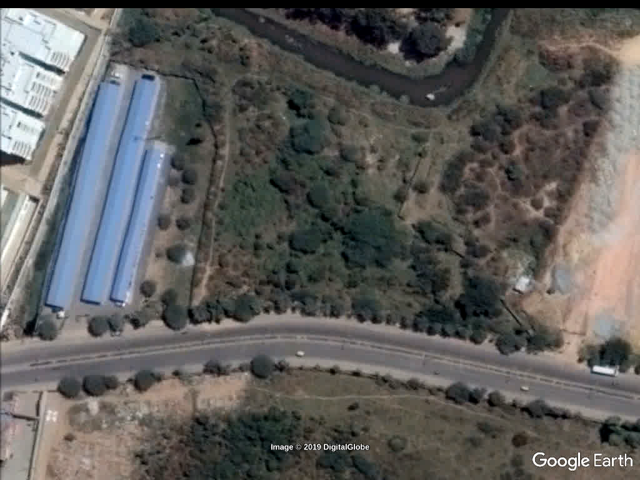

Corresponding Semantic Segmented image of input image


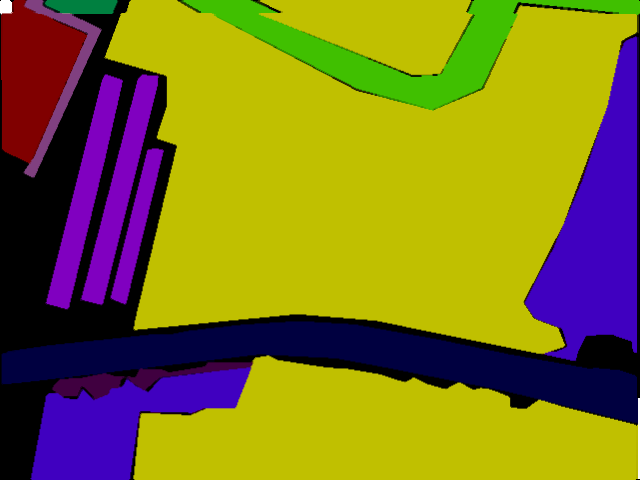

In [0]:
print('Input image for UNet:')
cv2_imshow(x_data[0].reshape(480,640,3))

print('Corresponding Semantic Segmented image of input image')
cv2_imshow(semantic_y_label[0].reshape(480,640,3))

$
Calculating\;unique\;the\;colour\;coordinates
$

In [0]:
pathc='/content/drive/My Drive/idp_data/idp_data/Manual_label/dtv_101250.png'
image = cv2.imread(pathc)

In [0]:
image=image.reshape(480,640,3)
colors=np.unique(image.reshape(-1, image.shape[2]), axis=0)

In [0]:
colors=colors/255
print(colors)
print('%d colors are present in semantic labels:'%(len(colors)))

[[0.         0.         0.        ]
 [0.         0.         0.50196078]
 [0.         0.50196078 0.50196078]
 [0.         0.75294118 0.75294118]
 [0.25098039 0.50196078 0.        ]
 [0.25098039 0.50196078 0.25098039]
 [0.50196078 0.25098039 0.50196078]
 [0.50196078 0.50196078 0.75294118]
 [0.75294118 0.         0.25098039]
 [0.75294118 0.50196078 0.        ]]
10 colors are present in semantic labels:


$
Convolution\;block:
$

In [0]:
class MyConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=None):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
        self.weight = nn.parameter.Parameter(torch.Tensor(
            out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.parameter.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels * self.kernel_size * self.kernel_size
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, padding=self.padding)


$
Unet\;model:
$

In [0]:
class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_in_channels,num_colours):
        super(UNet, self).__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            MyConv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            MyConv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            MyConv2d(num_filters*2*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            MyConv2d(num_filters*2, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = MyConv2d(3+num_in_channels, num_colours, kernel_size=kernel)

    def forward(self, x):
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.skip1 = torch.cat((self.out3,self.out2),1)
        self.out4 = self.upconv1(self.skip1)
        self.skip2 = torch.cat((self.out4,self.out1),1)
        self.out5 = self.upconv2(self.skip2)
        self.skip3 = torch.cat((self.out5,x),1)
        self.out_final = self.finalconv(self.skip3)
        return self.out_final

In [0]:
Model=UNet(kernel=3,num_filters=32,num_in_channels=3,num_colours=len(colors))
print(Model)

UNet(
  (downconv1): Sequential(
    (0): MyConv2d()
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (downconv2): Sequential(
    (0): MyConv2d()
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rfconv): Sequential(
    (0): MyConv2d()
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (upconv1): Sequential(
    (0): MyConv2d()
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
  )
  (upconv2): Sequential(
    (0): MyConv2d()
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3):

In [0]:
def get_rgb_cat(xs, colours):
    if np.shape(xs)[0] < 100:
        return _get_rgb_cat(xs,colours)
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next = _get_rgb_cat(xs[i:i+batch_size,:,:,:], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result

def _get_rgb_cat(xs, colours):
    num_colours = np.shape(colours)[0]
    xs = np.expand_dims(xs, 0)
    cs = np.reshape(colours, [num_colours,1,3,1,1])
    dists = np.linalg.norm(xs-cs, axis=2) # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return cat

def get_cat_rgb(cats, colours):
    return colours[cats]

def process(xs, ys, max_pixel=256.0):
    xs = xs / max_pixel
    # xs = xs[np.where(ys == 0)[0], :, :, :]
    npr.shuffle(xs)
    grey =xs
    # grey = np.mean(xs, axis=1, keepdims=True)
    return (xs, grey)


def get_batch(x, y, batch_size):
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i:i+batch_size, :,:,:]
        batch_y = y[i:i+batch_size, :,:,:]
        yield (batch_x, batch_y)

def get_torch_vars(xs, ys):
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    return Variable(xs), Variable(ys)

def compute_loss(criterion, outputs, labels, batch_size, num_colours):
    loss_out = outputs.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*480*640, num_colours])
    loss_lab = labels.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*480*640])
    return criterion(loss_out, loss_lab)



$
Train\;function:
$

In [0]:
def train(model,learn_rate,epochs,x_label,y_label,batch_size,colours):
    npr.seed(0)
    print('uploading colours...')
    # colours = np.load(colours,allow_pickle=True,encoding = 'latin1')[0]
    num_colours = np.shape(colours)[0]

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adagrad(model.parameters(), lr=learn_rate)


    print("Transforming data...")
    train_rgb, train_grey = process(x_label, y_label)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)

    train_grey=torch.tensor(train_grey).float()
    train_rgb_cat=torch.tensor(train_rgb_cat).long()

    train_tensor=torch.utils.data.TensorDataset(train_grey,train_rgb_cat)
    train_loader=torch.utils.data.DataLoader(dataset=train_tensor
                                           ,batch_size=batch_size
                                           ,shuffle=True)

    print("Beginning training ...")

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        model.train()
        losses = []
        for (X,Y) in train_loader:
            optimizer.zero_grad()
            outputs = model(X)

            loss = compute_loss(criterion,
                                outputs,
                                Y,
                                batch_size=batch_size,
                                num_colours=num_colours)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())


            avg_loss = np.mean(losses)
            train_losses.append(avg_loss)
            print('Epoch [%d/%d], Loss: %.4f' % (
                epoch+1, epochs, avg_loss))

    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    
    return model

$
Training\;UNet
$

Trained on 0 images
uploading colours...
Transforming data...
Beginning training ...
Epoch [1/10], Loss: 2.4870
Epoch [1/10], Loss: 2.3573
Epoch [1/10], Loss: 2.2860
Epoch [1/10], Loss: 2.2338
Epoch [1/10], Loss: 2.1929
Epoch [1/10], Loss: 2.1538
Epoch [2/10], Loss: 1.9256
Epoch [2/10], Loss: 1.9099
Epoch [2/10], Loss: 1.9004
Epoch [2/10], Loss: 1.8888
Epoch [2/10], Loss: 1.8748
Epoch [2/10], Loss: 1.8624
Epoch [3/10], Loss: 1.7881
Epoch [3/10], Loss: 1.7891
Epoch [3/10], Loss: 1.7863
Epoch [3/10], Loss: 1.7736
Epoch [3/10], Loss: 1.7606
Epoch [3/10], Loss: 1.7560
Epoch [4/10], Loss: 1.7206
Epoch [4/10], Loss: 1.7028
Epoch [4/10], Loss: 1.7086
Epoch [4/10], Loss: 1.6949
Epoch [4/10], Loss: 1.7010
Epoch [4/10], Loss: 1.6977
Epoch [5/10], Loss: 1.6550
Epoch [5/10], Loss: 1.6668
Epoch [5/10], Loss: 1.6681
Epoch [5/10], Loss: 1.6642
Epoch [5/10], Loss: 1.6620
Epoch [5/10], Loss: 1.6565
Epoch [6/10], Loss: 1.6082
Epoch [6/10], Loss: 1.6025
Epoch [6/10], Loss: 1.6158
Epoch [6/10], Loss: 1.61

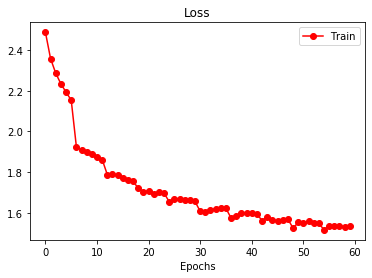

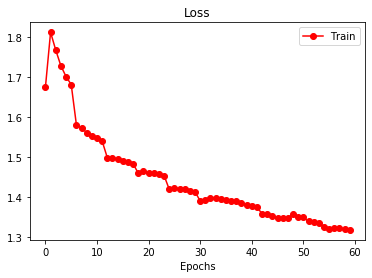

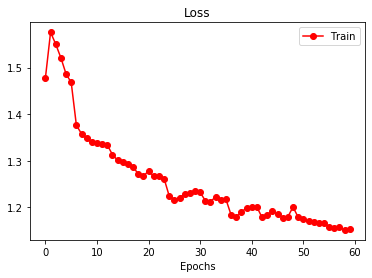

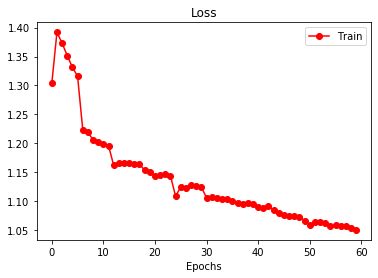

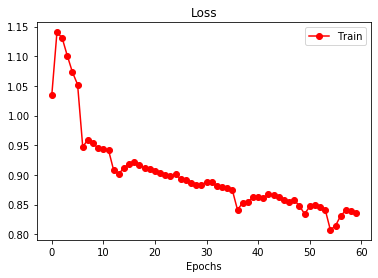

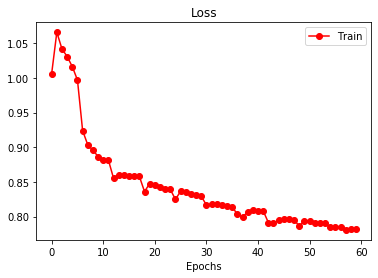

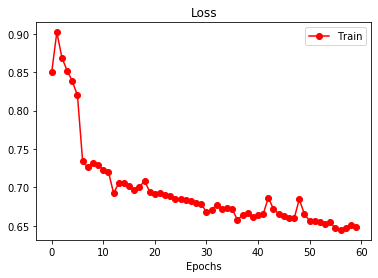

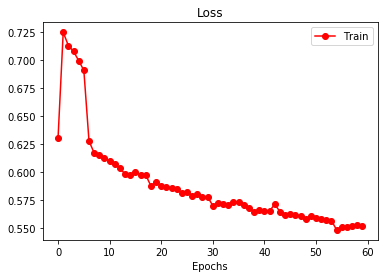

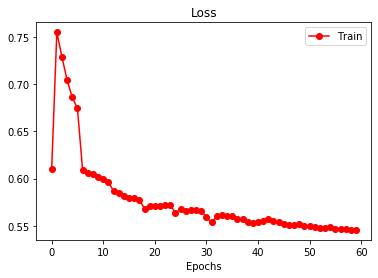

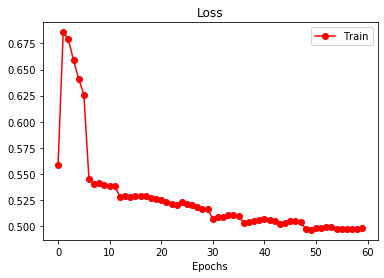

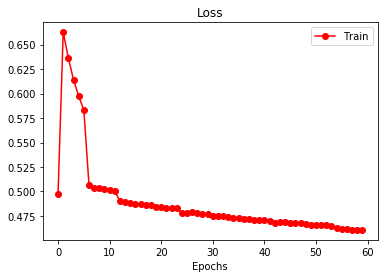

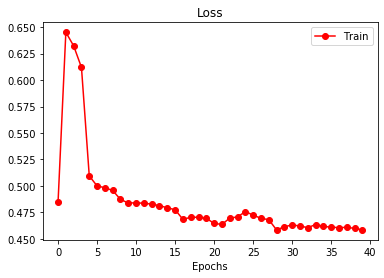

In [0]:
for i in range(0,np.shape(semantic_y_label)[0],30):
  print('Trained on %d images'%(i))
  Model=train(model=Model,
            learn_rate=0.01,
            epochs=10,
            x_label=x_data[i:i+30],
            y_label=semantic_y_label[i:i+30],
            batch_size=5,
            colours=colors)

$
Predictions
$

In [0]:
test_x, test_y= process(x_data[0:1], semantic_y_label[0:1])
test_images, test_labels = get_torch_vars(test_x, test_y)
pred=Model(test_images)

In [0]:
_,predicted = torch.max(pred.data, 1, keepdim=True)

In [0]:
out=get_cat_rgb(predicted,colours=colors)

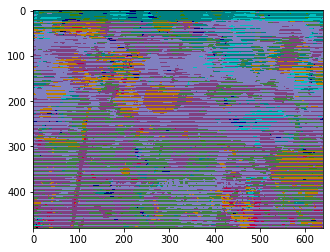

In [0]:
plt.imshow(out[0].reshape(480,640,3),vmin=0,vmax=1.)

$
Let\;the\;model\;contain\;four\;Fully\;connected\;layers(L1,L2,L3,L4).
\\Let\;w1,w2,w3\;be\;weight\;matrices\;between\;each\;layer.
\\Let\;A2,A3,A4\;be\;the\;activations\;of\;layers\;(L2,L3,L4)
\\Let\frac{\partial E}{\partial o}\;be\;\partial o.
\\\implies\;\partial w1=(\partial o)*(A4(o)^{'})*(w3)*(A3(L3)^{'})*(w2)*(A2(L2)^{'})
\\\implies This\;above\;term\;may\;vanish\;beacause\;derivatives\;of\;activation\;functions\;are\;less\;than\;1.
\\\implies To\;avoid\;this\;we\;are\;going\;add\;a\;skip\;layer\;from\;L4\;to\;L2.
\\Then\;\partial(new\;w1)=\partial(w1)(Due\;to\;back\;propagation)+\partial(o)(Due\;to\;skip\;layer)
\\\implies \partial(w1)=(\partial o)*(A4(o)^{'})*(w3)*(A3(L3)^{'})*(w2)*(A2(L2)^{'})+(\partial o)
\\In\;this\;way\;we\;can\;avoid\;vanishing\;gradient\;problem\;using\;skip\;layers.
\\This\;extra\;gradient\;is\;going\;to\;be\;a\;valid\;gradient\;because\;previously\;the\;model\;is\;trained\;for\;output(O)\;after\;adding\;skip\;layers\;it\;will\;trained\;for(output(o)-L2).
$